<p align="center">
  <b><font size="7">CombPlex Demonstration</font></b>
</p>

**CombPlex** (COMBinatorial multiPLEXing) is a combinatorial staining platform coupled with an algorithmic framework to exponentially increase the number of proteins that can be measured using any imaging modality. In CombPlex, every protein is imaged in several channels, and every channel contains agglomerated images of several proteins. These combinatorically-compressed images are then decompressed to individual protein-images using deep learning and optimization. This notebook leads you through an example of applying CombPlex.

This example aligns with the CODEX 7to3 experiment detailed in our paper. We employ a pre-trained model to perform inference on a subset of 4 FOVs. For each FOV, we decompress 3 compressed images into 7 single-protein images. Then, we compare our outcomes with the GT single-protein measurements, utilizing the same metrics as presented in our paper.

For comprehensive information, we recommend referring to our paper or exploring our code available on GitHub.

In [ ]:
#@title #### Mount your Google Drive and map your directory
#@markdown Please insert your directory path
from google.colab import drive
drive.mount('/content/gdrive')

# check Google Drive is mounted
import os
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

# cd the user directory path
dir_path = "/content/gdrive/MyDrive/CombPlex-main"  #@param{type:"string"}
%cd -q {dir_path}
print(f'Succesfully changed directory (cd) to "{dir_path}"')

Mounted at /content/gdrive
Succesfully changed directory (cd) to "/content/gdrive/MyDrive/CombPlex-main"


In [ ]:
#@title #### Imports
import gdown
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v2 as imageio
import torch
from scipy import ndimage
from scipy.stats import pearsonr
import numpy as np
import os
from sklearn.metrics import f1_score

In [ ]:
#@title #### Check your GPU avaibility
if torch.cuda.is_available():
    print('CUDA is available!')
else:
    print('CUDA is not available! Please connect to GPU for optimal perfomance')

CUDA is available!


In [ ]:
#@title #### Download Test-Set and Pre-trained Model
!mkdir datasets
gdown.download_folder("https://drive.google.com/drive/folders/1LOJXLU4M7hW3pK2hd2ok4j2qVaKqJiyc?usp=sharing", quiet=True)
!mv Test_CODEX_7to3_demo_dataset datasets/
!mkdir pretrained_models
gdown.download(id="1NccNJOpDEa8Bs4J9SFNJdnI1zSaLfn7d", output="CODEX_7to3_paper_exp.pt", quiet=True)
!mv CODEX_7to3_paper_exp.pt pretrained_models/

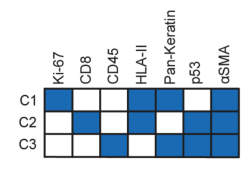

In [ ]:
#@title ## Compression Matrix
# @markdown The training and the inference process are following this compression matrix:
gdown.download(id="1P04J2-ZFQCiPBN60icrNKlrSDDdWaD0M", output="CODEX_7to3_compression_matrix.png", quiet=True)
plt.figure(figsize=(3, 2))
plt.imshow(plt.imread("CODEX_7to3_compression_matrix.png"))
plt.axis('off')  # Hide axis
plt.show()

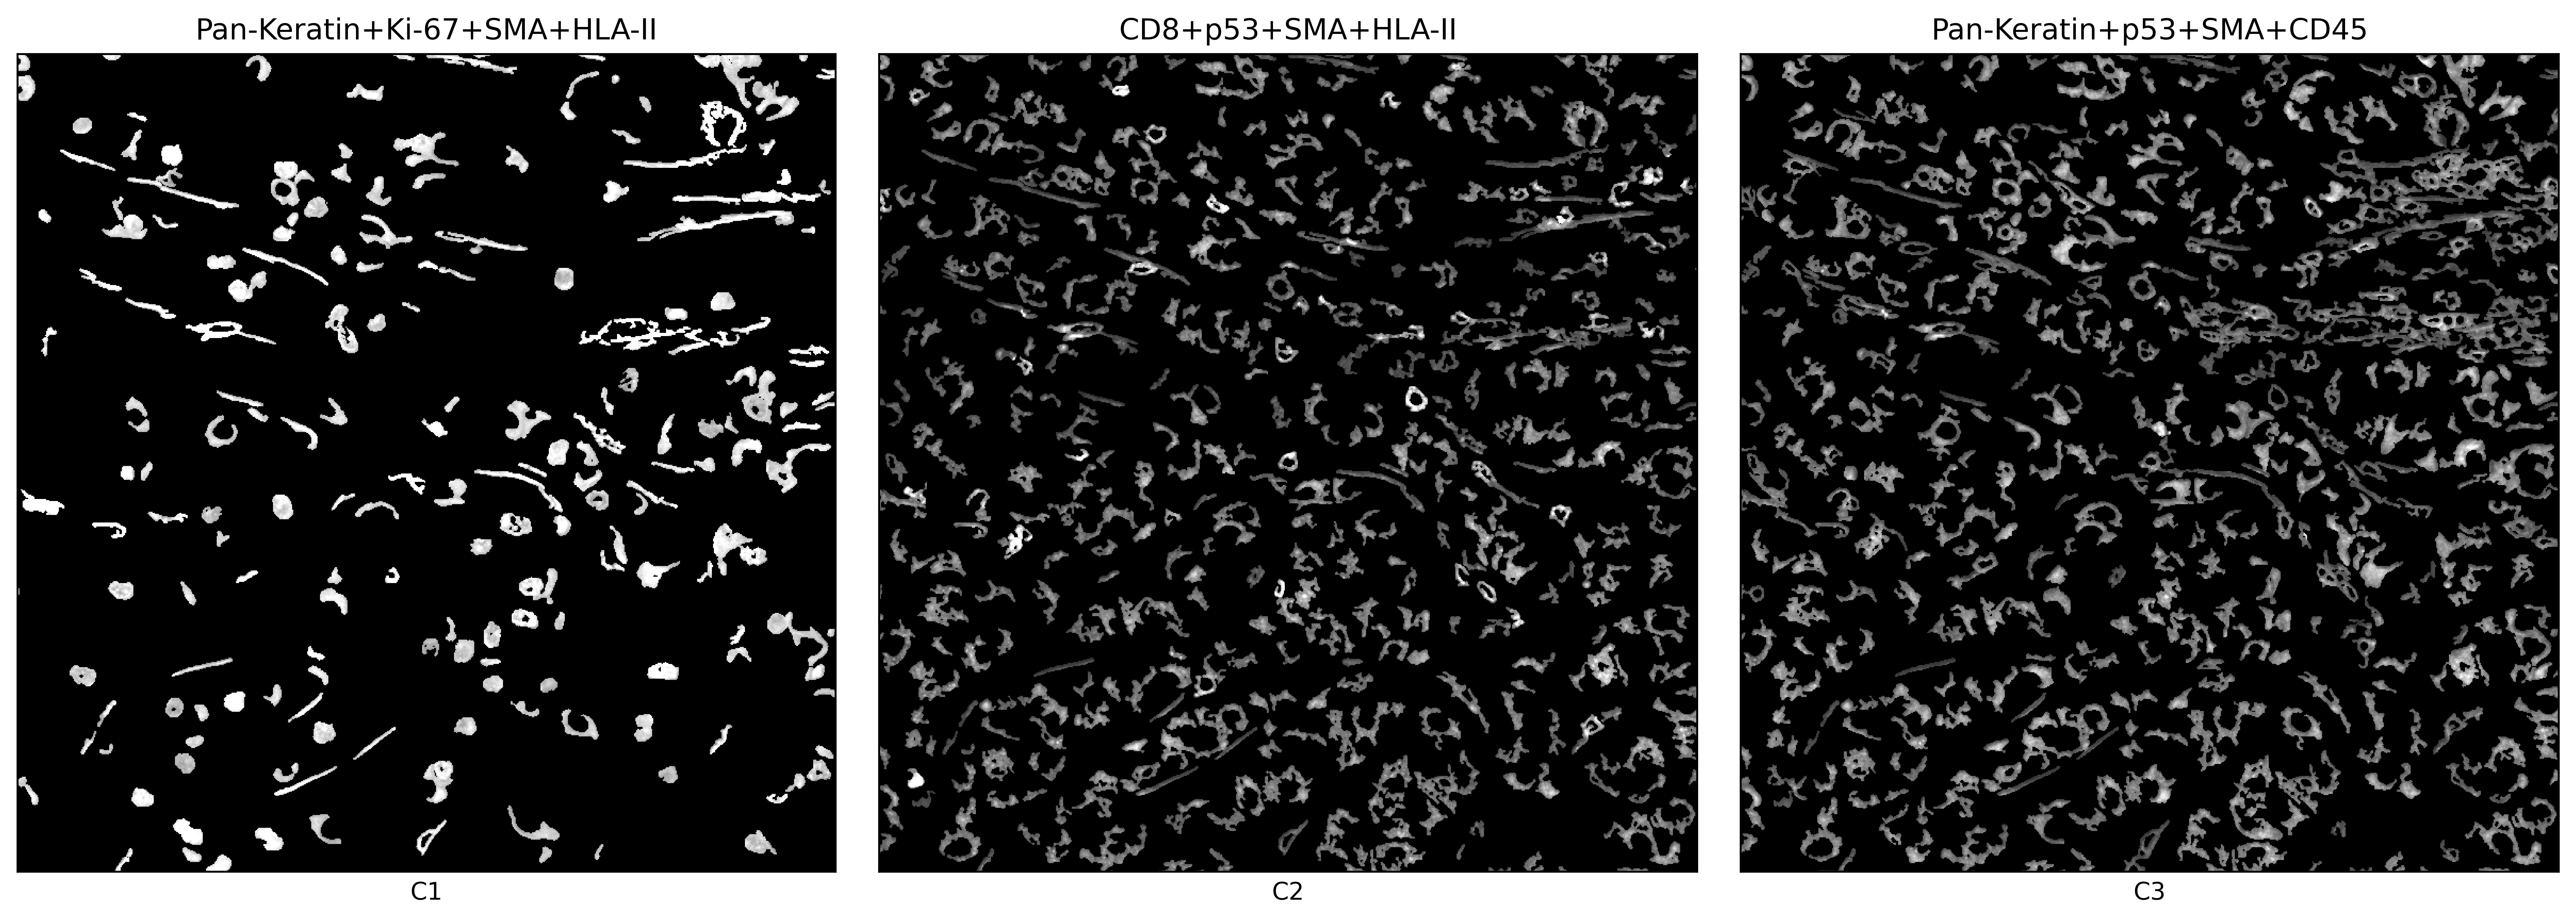

In [ ]:
#@title ## CombPlex's Input
# @markdown **CombPlex** utilizes compressed images that have been stained through a process involving the combination of multiple antibodies, as directed by our compression matrix. In our specific scenario, we are working with a set of three compressed images, each representing a combination of four proteins:

fov = 'C-11'  # choose fov: ['B-13' | 'C-11' | 'D-11' | 'G-7']
fov_path = f'datasets/Test_CODEX_7to3_demo_dataset/{fov}'

def normalize_and_clip_image(img, clip_range=(0, 0.3)):
    max_value = img.max()
    normalized_img = img / max_value  # Normalize pixel values

    clip_min, clip_max = clip_range
    clipped_img = np.clip(normalized_img, clip_min, clip_max)

    return (clipped_img * 255).astype(np.uint8)

# Define the center crop function
def center_crop(img, crop_size):
    y, x = img.shape[0], img.shape[1]
    startx = x // 2 - (crop_size // 2)
    starty = y // 2 - (crop_size // 2)
    return img[starty:starty + crop_size, startx:startx + crop_size]

# Path to the images
image_paths = [
    f'{fov_path}/Pan-Keratin-Ki67-SMA-HLA-DR_Clean.tif',
    f'{fov_path}/CD8-p53-SMA-HLA-DR_Clean.tif',
    f'{fov_path}/Pan-Keratin-p53-SMA-CD45_Clean.tif'
]

# titles and labels
titles = ['Pan-Keratin+Ki-67+SMA+HLA-II', 'CD8+p53+SMA+HLA-II', 'Pan-Keratin+p53+SMA+CD45']
labels = ['C1', 'C2', 'C3']

# Load the images using PIL
images = [center_crop(imageio.imread(path), 768) for path in image_paths]

# Normalize and clip images while preserving their relative proportions
normalized_clipped_images = [normalize_and_clip_image(img) for img in images]

# Plot the normalized and clipped images side by side
fig, axes = plt.subplots(1, len(normalized_clipped_images), figsize=(15, 5), dpi=600)

for ax, img, title, xlabel in zip(axes, normalized_clipped_images, titles, labels):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(xlabel)

plt.tight_layout()
plt.show()


In [ ]:
#@title ## Inference Procedure

#@markdown Execute the cell below to initiate CombPlex's inference process. This might take few minutes to complete the inference across all four FOVs. Once the inference process is finished, you will be able to locate all resulting files in the *results/CODEX7to3_demo_results* directory.

#@markdown Here, a pre-trained model is employed to forecast binary masks for the seven individual protein images. These masks are then utilized in a real-time optimization procedure to restore their corresponding intensities.

exec(open("inference.py", "r").read())

FOV C-11:
Iteration 0: loss=1526122.1250
Iteration 500: loss=5422.2280
Iteration 808: loss=5416.46630859
Early stopping condition achieved!
Inference process for FOV C-11 is done!

FOV D-11:
Iteration 0: loss=3857916.7500
Iteration 500: loss=5684.2803
Iteration 1000: loss=5657.5864
Iteration 1139: loss=5657.17724609
Early stopping condition achieved!
Inference process for FOV D-11 is done!

FOV G-7:
Iteration 0: loss=3262332.0000
Iteration 500: loss=7551.7744
Iteration 1000: loss=7499.8066
Iteration 1354: loss=7497.45703125
Early stopping condition achieved!
Inference process for FOV G-7 is done!



In [ ]:
#@title ## Visualization and Analysis of the Results
#@markdown In the display below, you can observe the outcomes. Each row corresponds to a distinct protein, and the columns are as follows:
#@markdown 1. **Ground Truth (GT) Image**
#@markdown 2. **Predicted Image**
#@markdown 3. **Overlay**: Overlay of the ground truth (green) and the prediction (magenta), with overlapping regions displayed in white. The corresponding F1 score, representing the accuracy of the prediction, is mentioned below this overlay.
#@markdown 4. **Intensity Comparison Graph**: A graph that compares the intensities of the intersecting pixels. The Pearson coefficient, which measures the correlation between the two intensities, is provided underneath the graph.


protein_names = ['Ki67', 'CD8', 'CD45', 'HLA-DR', 'Pan-Keratin', 'p53', 'SMA']
results_path = f'results/CODEX7to3_demo_results/{fov}'

fig, axes = plt.subplots(7, 4, figsize=(20, 40), dpi=600)

for i, protein in enumerate(protein_names):
    # read images
    protein_GT_img = imageio.imread(os.path.join(results_path, f'{protein}.tif'))[0]
    protein_recon_filename = [filename for filename in os.listdir(results_path) if filename.startswith(f'recon_{protein}')][0]
    protein_recon_img = imageio.imread(os.path.join(results_path, protein_recon_filename))[0]

    # Ground Truth Image
    axes[i, 0].imshow(normalize_and_clip_image(protein_GT_img), cmap=mcolors.ListedColormap([(0,0,0), (0,1,0)]))
    axes[i, 0].set_title("Ground Truth", fontsize=16)
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xticks([])
    axes[i, 0].set_ylabel(f'{protein}', fontsize=16)

    # Predicted Image
    axes[i, 1].imshow(normalize_and_clip_image(protein_recon_img), cmap=mcolors.ListedColormap([(0,0,0), (0.5,0,0.5)]))
    axes[i, 1].set_title("Predicted", fontsize=16)
    axes[i, 1].set_yticks([])
    axes[i, 1].set_xticks([])

    # Overlay Image
    GT_mask = protein_GT_img > 0
    recon_mask = protein_recon_img > 0
    intersection_mask = GT_mask * recon_mask
    overlay_rgb = np.zeros((intersection_mask.shape[0], intersection_mask.shape[1], 3), dtype=np.uint8)
    overlay_rgb[intersection_mask] = [0, 255, 0]  # Green for FN (False Negative)
    overlay_rgb[recon_mask] = [255, 0, 255]  # Magenta for FP (False Positive)
    overlay_rgb[GT_mask] = [255, 255, 255]  # White for TP (True Positive)
    f1_score_img = f1_score(GT_mask.flatten(), recon_mask.flatten())
    axes[i, 2].imshow(overlay_rgb)
    axes[i, 2].set_title('Overlayed', fontsize=16)
    axes[i, 2].set_yticks([])
    axes[i, 2].set_xticks([])
    axes[i, 2].set_xlabel(f'F1 score = {f1_score_img:.3f}', fontsize=16)

    # Intensity Comparison Graph
    GT_protein_mask = protein_GT_img > 0
    recon_protein_mask = protein_recon_img > 0
    intersection_mask = GT_protein_mask & recon_protein_mask
    # calculating Pearson correlation
    if np.all(intersection_mask==False):
        correlation_coefficient = 1
    else:
        # Applying average pooling and Neglecting pixels that aren't in the intersection
        protein_GT_img = ndimage.uniform_filter(protein_GT_img, size=5) * intersection_mask
        protein_recon_img = ndimage.uniform_filter(protein_recon_img, size=5) * intersection_mask
        # Take the non zero pixels and flatten the images into 1D arrays
        GT_protein_flat = protein_GT_img[protein_GT_img > 0]
        recon_protein_flat = protein_recon_img[protein_recon_img > 0]
        # Calculate the Spearman correlation coefficient and p-value
        correlation_coefficient, _ = pearsonr(GT_protein_flat, recon_protein_flat)
    axes[i, 3].scatter(GT_protein_flat, recon_protein_flat, c='blue')
    axes[i, 3].plot([0, 1], [0, 1], transform=axes[i, 3].transAxes, color='black')
    axes[i, 3].set_xlabel(f'GT Intensity\n Pearson = {correlation_coefficient:.3f}', fontsize=16)
    axes[i, 3].set_ylabel('Predicted Intensity', fontsize=16)
    axes[i, 3].set_title("Intensity Comparison", fontsize=16)
    aspect = axes[i, 0].get_data_ratio()
    axes[i, 3].set_aspect(aspect)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.